# Saving Loess Detrended Data
Saving all data with loess detrend.

<b> PHD-1 </b>
* Switched read_and_merge_netcdfs from longrunmip_loaded function to open_ds - all opening files are now done within the one py file
* longrunmip loader removed. Better just to load files in one by one
* Moved from init to top level
* Removed all extra code (see nb 23 in init for old code).


In [60]:
import xarray as xr
from importlib import reload
import numpy as np
import pandas as pd
import os
# from glob import glob
from time import perf_counter
import matplotlib.pyplot as plt
import sys
sys.path.append('modules')
import constants
import xarray_class_accessors as xca
import open_ds
# import signal_to_noise as sn
import utils
from classes import ExperimentTypes
from warnings import filterwarnings
filterwarnings('ignore')
from itertools import chain
from functools import partial
from time import perf_counter
from multiprocessing import Pool

In [113]:
# Notes: Surf contains a T cell extra variable and also return divide by 0 error.
variable = 'tas' # pr, tas

ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable,'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [114]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [115]:
files_to_open_abrupt4x = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                                    ExperimentTypes.ABRUPT4X, 
                                                                    models_to_get)
utils.pprint_list(files_to_open_abrupt4x)

lenght = 7
 0. tas_mon_CCSM3_abrupt4x_2120_g025.nc
 1. tas_mon_CESM104_abrupt4x_5900_g025.nc


In [116]:
files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                                    ExperimentTypes.CONTROL, 
                                                                    models_to_get)
utils.pprint_list(files_to_open_control)

lenght = 7
 0. tas_mon_CCSM3_control_1530_g025.nc
 1. tas_mon_CESM104_control_1000_g025.nc


# Functions

In [52]:
def get_lowess_metadata() -> dict[str, str]:
    now = pd.Timestamp.now().strftime(format = '%Y/%m/%d')
    history = {'history': f'Modified by Alex Borowiak on {now}','stats': 'loess detrended data'}
    return history

In [67]:
def open_and_data_and_apply_loess_filter(fname, ROOT_DIR, OUTPUT_DIR):
    print(f'{fname} -> {os.path.join(OUTPUT_DIR, fname)}\n')
    ds = xr.open_dataarray(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks)
    
    ds_loess = ds.sn.loess_grid()
    
    ds_loess.attrs = {**ds_loess.attrs, **get_lowess_metadata()}
    
    ds_loess.to_netcdf(os.path.join(OUTPUT_DIR, fname))
    print(f'{fname} completed') 

# Single Model Sample

In [7]:
fname = files_to_open_abrupt4x[0]
fname

'pr_mon_CCSM3_abrupt4x_2120_g025.nc'

In [8]:
REGRID_LAT = 72
REGRID_LON = 144

In [9]:
chunks = {'lat':72/4,'lon':144/4,'time':-1}
ds = xr.open_dataarray(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks)
ds

<xarray.DataArray 'pr' (time: 2120, lat: 72, lon: 144)>
dask.array<open_dataset-4f3c089d423134f74869e4d4ed5548f2pr, shape=(2120, 72, 144), dtype=float32, chunksize=(2120, 18, 36), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 2120-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [28]:
%%time
# Time taken for pr_mon_CCSM3_abrupt4x_2120_g025: 1h 9min 44s
ds_loess = ds.sel(lat=slice(-20, -15), lon=slice(110, 115)).sn.loess_grid()

CPU times: user 1.9 s, sys: 86 ms, total: 1.99 s
Wall time: 2.01 s


In [29]:
ds_loess.attrs = {**ds_loess.attrs, **get_lowess_metadata()}

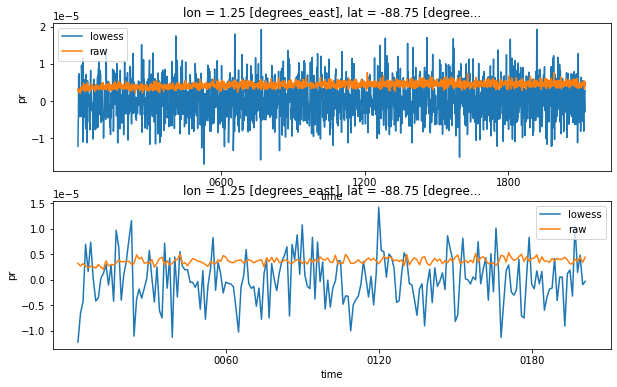

In [40]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6))
ds_loess.isel(lat=0, lon=0).plot(ax=ax1, label='lowess')
ds.isel(lat=0, lon=0).plot(ax=ax1, label='raw')
ax1.legend()

ds_loess.isel(lat=0, lon=0, time=slice(0,200)).plot(ax=ax2,label='lowess')
ds.isel(lat=0, lon=0, time=slice(0,200)).plot(ax=ax2, label='raw')
ax2.legend()

# All Files

In [97]:
chunks = {'lat':72/4,'lon':144/4,'time':-1}

In [98]:
OUTPUT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable, 'lowess')
OUTPUT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/sic/lowess'

In [99]:
try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError as e:
    pass

In [100]:
len(files_to_open_control+files_to_open_abrupt4x)

13

In [101]:
MAX_LENGTH = 1200

In [126]:
files_to_open_control

['tas_mon_CCSM3_control_1530_g025.nc',
 'tas_mon_CESM104_control_1000_g025.nc',
 'tas_mon_CNRMCM61_control_2000_g025.nc',
 'tas_mon_HadCM3L_control_1000_g025.nc',
 'tas_mon_IPSLCM5A_control_1000_g025.nc',
 'tas_ann_MPIESM11_control_2000_g025.nc',
 'tas_mon_MPIESM12_control_1237_g025.nc']

In [106]:
failed_files = []
for i,fname in enumerate(chain(files_to_open_control, files_to_open_abrupt4x)):
    t1 = perf_counter()
    print(f'{i+1}: {fname} ', end='')
    try:
        da = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks).to_array()
        da = da.isel(time=slice(None, MAX_LENGTH))

        da_loess = da.sn.loess_grid()

        da_loess.attrs = {**ds_loess.attrs, **get_lowess_metadata()}

        print(f' -> {os.path.join(OUTPUT_DIR, fname)}', end ='')
        da_loess.to_netcdf(os.path.join(OUTPUT_DIR, fname))
        t2 = perf_counter()
        print(f' ({t2-t1})')
    except ZeroDivisionError as e:
        failed_files.append({fname: 'ZeroDivisionError'})
        print(e)

1: sic_mon_CNRMCM61_control_2000_g025.ncdivision by zero
2: sic_mon_HadCM3L_control_1000_g025.ncdivision by zero
3: sic_mon_IPSLCM5A_control_1200_g025.ncdivision by zero
4: sic_mon_MPIESM11_control_2000_g025.ncdivision by zero
5: sic_mon_MPIESM12_control_1500_g025.ncdivision by zero
6: sic_mon_CCSM3_abrupt4x_2120_g025.nc -> /g/data/w40/ab2313/PhD/longrunmip/sic/lowess/sic_mon_CCSM3_abrupt4x_2120_g025.nc (2278.8056756611913)
7: sic_mon_CNRMCM61_abrupt4x_1850_g025.ncdivision by zero
8: sic_mon_HadCM3L_abrupt4x_1000_g025.ncdivision by zero
9: sic_mon_IPSLCM5A_abrupt4x_1000_g025.ncdivision by zero
10: sic_mon_MPIESM11_abrupt4x_4520_g025.ncdivision by zero
11: sic_mon_MPIESM12_abrupt4x_1000_g025.ncdivision by zero


# With MulitProcessing

In [109]:
from functools import partial
from multiprocessing import Pool

In [123]:
import utils
logger = utils.get_notebook_logger()

In [ ]:
OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'test_csm')

try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError as e:
    pass

In [124]:
utils.change_logging_level('DEBUG')

In [112]:
def open_and_data_and_apply_loess_filter(fname, ROOT_DIR, OUPTUT_DIR):
    t1 = perf_counter()
    logger.info(f'{i+1}: {fname} ', end='')
    try:
        da = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks).to_array()
        da = da.isel(time=slice(None, MAX_LENGTH))

        da_loess = da.sn.loess_grid()

        da_loess.attrs = {**ds_loess.attrs, **get_lowess_metadata()}

        logger.debug(f' -> {os.path.join(OUTPUT_DIR, fname)}', end ='')
        da_loess.to_netcdf(os.path.join(OUTPUT_DIR, fname))
        t2 = perf_counter()
        logger.debug(f' ({t2-t1})')
    except ZeroDivisionError as e:
        failed_files.append({fname: 'ZeroDivisionError'})
        logger.error(e)

In [110]:
open_and_data_and_apply_loess_filter_partial = partial(open_and_data_and_apply_loess_filter,
                                              ROOT_DIR=ROOT_DIR, OUTPUT_DIR=OUTPUT_DIR)

In [70]:
%%time
with Pool() as pool:
    pool.map(open_and_data_and_apply_loess_filter_partial, 
             chain(files_to_open_control, files_to_open_abrupt4x))